## Traffic Sign Recognition and Vision Transformer (ViT) with TensorFlow 

In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

In [3]:
#@title Helper functions for loading image (hidden)

original_image_cache = {}

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

def load_image_from_url(img_url):
  """Returns an image with shape [1, height, width, num_channels]."""
  user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
  response = requests.get(img_url, headers=user_agent)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_url in original_image_cache:
    img = original_image_cache[image_url]
  elif image_url.startswith('https://'):
    img = load_image_from_url(image_url)
  else:
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
  original_image_cache[image_url] = img
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img, img_raw

def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

image_size = 224
dynamic_size = False

Select an Image Classification model

In [4]:
# Select an Image Classification model

model_name = "vit-b8"

model_handle_map = {
  "vit-b8": "/kaggle/input/vision-transformer/tensorflow2/vit-b8-classification/1",
#   "evit-b8": "/kaggle/input/vision-transformer/tensorflow2/vit-b8-classification/1",
#   "vit-b8": "/kaggle/input/efficientnet-v2/tensorflow2/imagenet1k-b0-classification/versions/1",
#   "vit-b8": "https://kaggle.com/models/kaggle/vision-transformer/frameworks/TensorFlow2/variations/vit-b8-classification/",
#   "vit-b8": "https://kaggle.com/models/kaggle/vision-transformer/frameworks/TensorFlow2/variations/vit-b8-classification/versions/1",
#   "vit-b8": "https://tfhub.dev/sayakpaul/vit_b8_classification/1",
}


model_image_size_map = {
  "vit-b8": 224,
}

model_handle = model_handle_map[model_name]

print(f"Selected model: {model_name} : {model_handle}")

Selected model: vit-b8 : /kaggle/input/vision-transformer/tensorflow2/vit-b8-classification/1


In [5]:
max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []

with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels]


Images will be converted to 224x224
24576/10484 [======================================================================] - 0s 0us/step


Select a model

In [9]:
model_name = "vit-b8"

model_handle_map = {
  "vit-b8": "/kaggle/input/vision-transformer/tensorflow2/vit-b8-fe/1",
#   "evit-b8": "/kaggle/input/vision-transformer/tensorflow2/vit-b8-fe/1",
#   "vit-b8": "/kaggle/input/vision-transformer/tensorflow2/vit-b8-fe/versions/1",
#   "vit-b8": "https://kaggle.com/models/kaggle/vision-transformer/frameworks/TensorFlow2/variations/vit-b8-fe/",
#   "vit-b8": "https://kaggle.com/models/kaggle/vision-transformer/frameworks/TensorFlow2/variations/vit-b8-fe/versions/1",
#   "vit-b8": "https://tfhub.dev/sayakpaul/vit_b8_fe/1",
}

model_image_size_map = {
  "vit-b8": 224,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: vit-b8 : /kaggle/input/vision-transformer/tensorflow2/vit-b8-fe/1
Input size (224, 224)


Select a dataset to fine-tune the model against

In [10]:
# data_dir = '/kaggle/input/traffic-sign-in-bangladesh/bd_traffic_sign_dataset'
data_dir = '/kaggle/input/traffic-sign/new dataset TS - Copy'
print(data_dir)

/kaggle/input/traffic-sign/new dataset TS - Copy


In [11]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 15259 files belonging to 24 classes.
Using 12208 files for training.
Found 15259 files belonging to 24 classes.
Using 3051 files for validation.


In [12]:
do_fine_tuning = False 

print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with /kaggle/input/vision-transformer/tensorflow2/vit-b8-fe/1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 768)               85807872  
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                18456     
Total params: 85,826,328
Trainable params: 18,456
Non-trainable params: 85,807,872
_________________________________________________________________


Training the model

In [13]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.004, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
# hist = model.fit(
#     train_ds,
#     epochs=10, steps_per_epoch=steps_per_epoch,
#     validation_data=val_ds,
#     validation_steps=validation_steps).history


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# # Define the ReduceLROnPlateau callback
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',    # Metric to monitor
#     factor=0.5,            # Factor by which the learning rate will be reduced
#     patience=3,            # Number of epochs with no improvement before reducing LR
#     min_lr=1e-6,           # Minimum learning rate
#     verbose=1              # Print messages when reducing the LR
# )

# Fit the model
hist = model.fit(
    train_ds,
    epochs=25,  # Increase epochs since early stopping will terminate early if needed
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, early_stopping]
).history


Epoch 1/25
763/763 [==============================] - 918s 1s/step - loss: 3.6818 - accuracy: 0.7009 - val_loss: 2.2867 - val_accuracy: 0.8813
Epoch 2/25
763/763 [==============================] - 900s 1s/step - loss: 2.4689 - accuracy: 0.8271 - val_loss: 2.2860 - val_accuracy: 0.8734
Epoch 3/25
763/763 [==============================] - 900s 1s/step - loss: 2.2566 - accuracy: 0.8517 - val_loss: 1.7646 - val_accuracy: 0.9355
Epoch 4/25
763/763 [==============================] - 900s 1s/step - loss: 2.2584 - accuracy: 0.8500 - val_loss: 1.6784 - val_accuracy: 0.9503
Epoch 5/25
763/763 [==============================] - 900s 1s/step - loss: 2.1778 - accuracy: 0.8566 - val_loss: 1.7016 - val_accuracy: 0.9536
Epoch 6/25
763/763 [==============================] - 900s 1s/step - loss: 2.1785 - accuracy: 0.8565 - val_loss: 1.7068 - val_accuracy: 0.9391

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0020000000949949026.
Epoch 7/25
763/763 [==============================] - 898s 1s

In [14]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


191/191 [==============================] - 185s 969ms/step - loss: 0.6927 - accuracy: 0.9971
Validation Loss: 0.692668080329895
Validation Accuracy: 0.9970501661300659


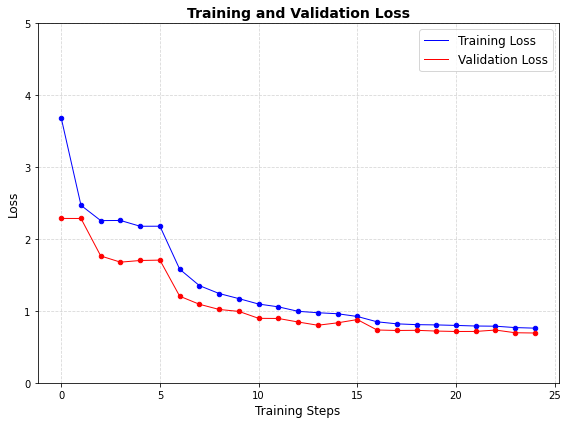

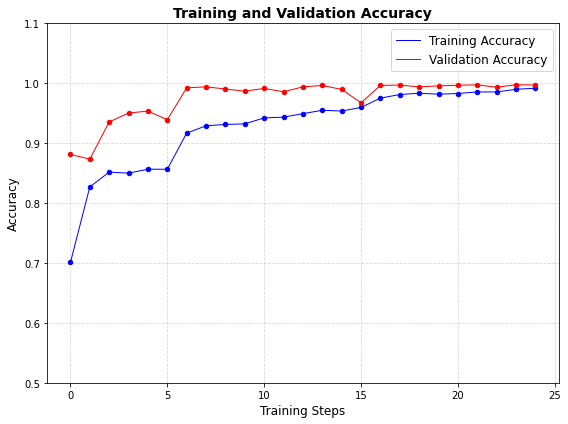

In [15]:
import matplotlib.pyplot as plt

# Assuming hist is a dictionary with keys: 'loss', 'val_loss', 'accuracy', 'val_accuracy', and 'epochs' (list of epoch indices)

# Plot Loss
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(hist["loss"], label="Training Loss", color="blue", linestyle="-", linewidth=1)
plt.plot(hist["val_loss"], label="Validation Loss", color="red", linestyle="-", linewidth=1)
# Mark each epoch
plt.scatter(range(len(hist["loss"])), hist["loss"], color="blue", s=20, zorder=3)
plt.scatter(range(len(hist["val_loss"])), hist["val_loss"], color="red", s=20, zorder=3)
plt.title("Training and Validation Loss", fontsize=14, fontweight="bold")
plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.ylim([0, 5])  # Adjust limits based on data
plt.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=300)  # Save figure for journal submission
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(hist["accuracy"], label="Training Accuracy", color="blue", linestyle="-", linewidth=1)
plt.plot(hist["val_accuracy"], label="Validation Accuracy", color="red", linestyle="-", linewidth=1)
# Mark each epoch
plt.scatter(range(len(hist["accuracy"])), hist["accuracy"], color="blue", s=20, zorder=3)
plt.scatter(range(len(hist["val_accuracy"])), hist["val_accuracy"], color="red", s=20, zorder=3)
plt.title("Training and Validation Accuracy", fontsize=14, fontweight="bold")
plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim([0.5, 1.1])  # Accuracy range
plt.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("accuracy_curve.png", dpi=300)  # Save figure for journal submission
plt.show()

In [16]:
# Initialize lists for true and predicted labels
y_true_indices = []
y_pred_indices = []
y_score_list = []

# Loop through the validation dataset
for x_batch, y_batch in val_ds:
    # Loop through each image in the batch
    for i in range(len(x_batch)):
        # Extract the image and its true label
        image = x_batch[i]
        true_index = np.argmax(y_batch[i])  # True label index
        y_true_indices.append(true_index)
        
        # Predict the label
        prediction_scores = model.predict(np.expand_dims(image, axis=0), verbose=0)
        
        y_scores_prob = np.exp(prediction_scores) / np.sum(np.exp(prediction_scores), axis=1, keepdims=True)
        y_score_list.append(y_scores_prob)
        
        predicted_index = np.argmax(prediction_scores)  # Predicted label index
        y_pred_indices.append(predicted_index)

# Print the collected indices
print("y_true_indices:", y_true_indices[:15])  # Show first 15 for brevity
print("y_pred_indices:", y_pred_indices[:15])  # Show first 15 for brevity


y_true_indices: [7, 20, 17, 18, 7, 13, 17, 17, 3, 2, 5, 22, 0, 21, 7]
y_pred_indices: [7, 20, 17, 18, 7, 13, 17, 17, 3, 2, 5, 22, 0, 21, 7]


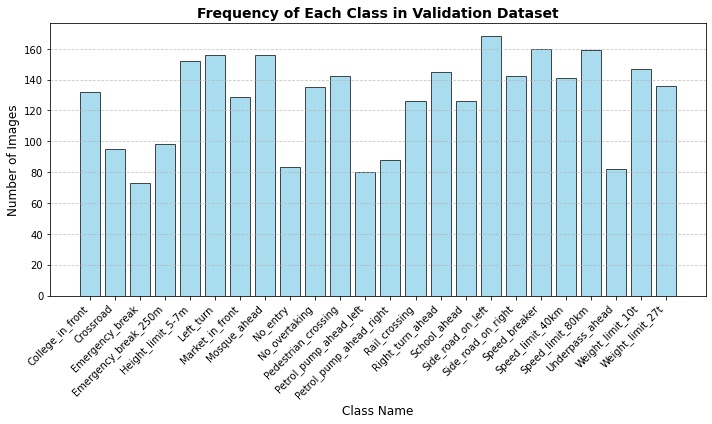

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a dictionary to count the occurrences of each class
class_counts = {class_name: 0 for class_name in class_names}

# Iterate through the validation dataset to count class occurrences
for _, labels in val_ds.unbatch():
    class_indices = np.argmax(labels.numpy(), axis=-1)  # Get class index for each label
    class_name = class_names[class_indices]
    class_counts[class_name] += 1

# Extract class names and counts for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color="skyblue", edgecolor="black", alpha=0.7)
plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate class names for readability
plt.title("Frequency of Each Class in Validation Dataset", fontsize=14, fontweight="bold")
plt.xlabel("Class Name", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
# for i, count in enumerate(counts):
#     plt.text(i, count + 0.5, str(count), ha='center', fontsize=10, fontweight="bold")
plt.tight_layout()
plt.savefig("class_frequency_plot.png", dpi=300)  # Save the plot for journal submission
plt.show()


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_true and y_pred are arrays of shape (1677, 13) with class indices

# Accuracy
accuracy = accuracy_score(y_true_indices, y_pred_indices)
print(f"Accuracy: {accuracy:.6f}")

# Precision, Recall, and F1-Score for multi-class classification (use 'weighted' average to account for class imbalance)
precision = precision_score(y_true_indices, y_pred_indices, average='weighted')
recall = recall_score(y_true_indices, y_pred_indices, average='weighted')
f1 = f1_score(y_true_indices, y_pred_indices, average='weighted')

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-Score: {f1:.6f}")


Accuracy: 0.997050
Precision: 0.997076
Recall: 0.997050
F1-Score: 0.997051


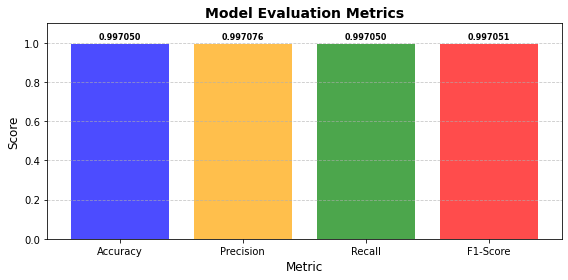

In [19]:
# Bar Plot
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Value": [accuracy, precision, recall, f1]
}
plt.figure(figsize=(8, 4))
plt.bar(metrics_data["Metric"], metrics_data["Value"], color=["blue", "orange", "green", "red"], alpha=0.7)
plt.ylim([0, 1.1])  # Metrics range between 0 and 1
plt.title("Model Evaluation Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
for i, v in enumerate(metrics_data["Value"]):
    plt.text(i, v + 0.02, f"{v:.6f}", ha='center', fontsize=8, fontweight="bold")
plt.tight_layout()
plt.savefig("metrics_barplot.png", dpi=400)  # Save figure for journal submission
plt.show()


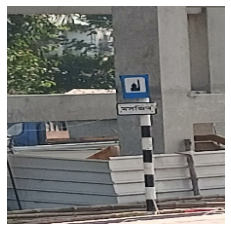

True label: Mosque_ahead
Predicted label: Mosque_ahead


In [21]:
x, y = next(iter(val_ds))
image = x[1, :, :, :]
true_index = np.argmax(y[1])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])


y_true shape: (3051, 24)
y_scores shape: (3051, 24)
Macro-Averaged AUC: 0.999964
Micro-Averaged AUC: 0.999957


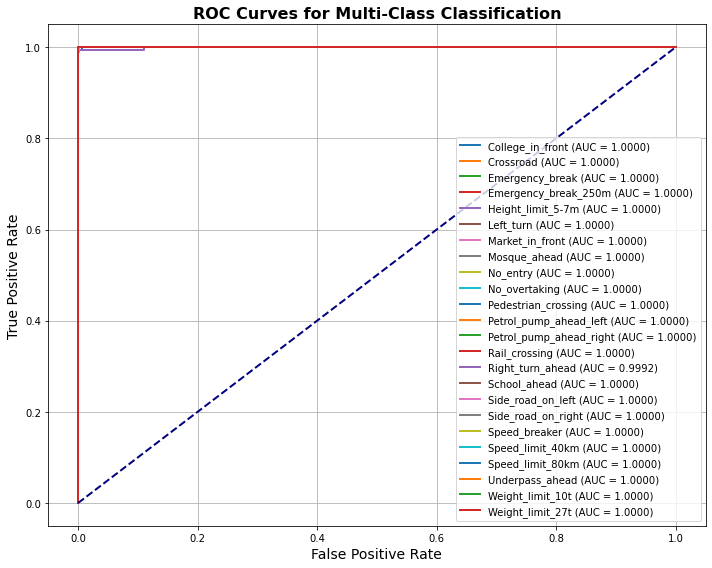

In [22]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Example true labels and predicted probabilities
y_true = y_true_indices  # Replace with your true labels (shape: (1677,))
y_scores = np.array(y_score_list)  # Predicted probabilities (shape: (1677, 24))
y_scores = np.squeeze(y_scores)

# Class names corresponding to each index
class_names = [
    "College_in_front",
    "Crossroad",
    "Emergency_break",
    "Emergency_break_250m",
    "Height_limit_5-7m",
    "Left_turn",
    "Market_in_front",
    "Mosque_ahead",
    "No_entry",
    "No_overtaking",
    "Pedestrian_crossing",
    "Petrol_pump_ahead_left",
    "Petrol_pump_ahead_right",
    "Rail_crossing",
    "Right_turn_ahead",
    "School_ahead",
    "Side_road_on_left",
    "Side_road_on_right",
    "Speed_breaker",
    "Speed_limit_40km",
    "Speed_limit_80km",
    "Underpass_ahead",
    "Weight_limit_10t",
    "Weight_limit_27t"
] # Replace with your actual class names

# Binarize the true labels (one-hot encoding)
n_classes = len(class_names)  # Number of classes
y_true_onehot = label_binarize(y_true, classes=np.arange(n_classes))

# Check shapes to ensure correctness
print(f"y_true shape: {y_true_onehot.shape}")  # Should be (1677, 24)
print(f"y_scores shape: {y_scores.shape}")  # Should be (1677, 24)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # For each class, pass the true binary labels and the predicted probabilities
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Macro-Averaged and Micro-Averaged AUC
macro_auc = np.mean(list(roc_auc.values()))
micro_auc = roc_auc_score(y_true_onehot, y_scores, average="micro")

print(f"Macro-Averaged AUC: {macro_auc:.6f}")
print(f"Micro-Averaged AUC: {micro_auc:.6f}")

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')

# Plot the diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('ROC Curves for Multi-Class Classification', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_with_labels.png")
plt.show()


y_true shape: (3051, 24)
y_scores shape: (3051, 24)
Macro-Averaged AUC: 0.999964
Micro-Averaged AUC: 0.999957


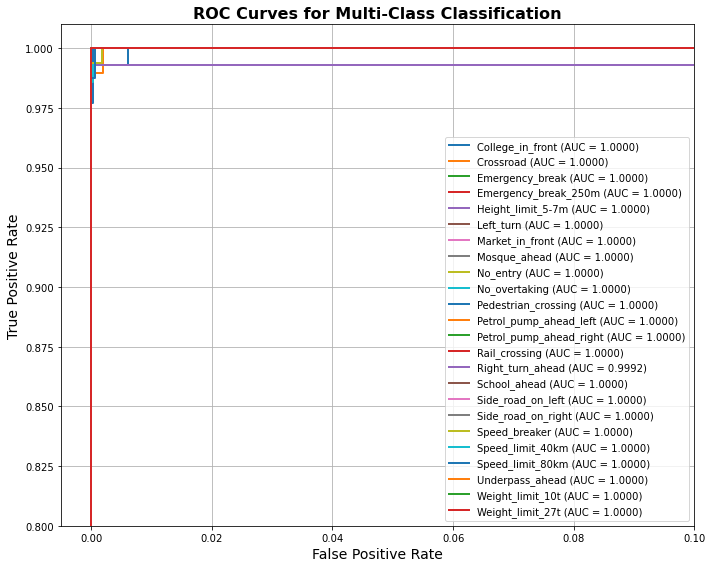

In [23]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Example true labels and predicted probabilities
y_true = y_true_indices  # Replace with your true labels (shape: (1677,))
y_scores = np.array(y_score_list)  # Predicted probabilities (shape: (1677, 24))
y_scores = np.squeeze(y_scores)

# Class names corresponding to each index
class_names = [
    "College_in_front",
    "Crossroad",
    "Emergency_break",
    "Emergency_break_250m",
    "Height_limit_5-7m",
    "Left_turn",
    "Market_in_front",
    "Mosque_ahead",
    "No_entry",
    "No_overtaking",
    "Pedestrian_crossing",
    "Petrol_pump_ahead_left",
    "Petrol_pump_ahead_right",
    "Rail_crossing",
    "Right_turn_ahead",
    "School_ahead",
    "Side_road_on_left",
    "Side_road_on_right",
    "Speed_breaker",
    "Speed_limit_40km",
    "Speed_limit_80km",
    "Underpass_ahead",
    "Weight_limit_10t",
    "Weight_limit_27t"
] # Replace with your actual class names

# Binarize the true labels (one-hot encoding)
n_classes = len(class_names)  # Number of classes
y_true_onehot = label_binarize(y_true, classes=np.arange(n_classes))

# Check shapes to ensure correctness
print(f"y_true shape: {y_true_onehot.shape}")  # Should be (1677, 24)
print(f"y_scores shape: {y_scores.shape}")  # Should be (1677, 24)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # For each class, pass the true binary labels and the predicted probabilities
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Macro-Averaged and Micro-Averaged AUC
macro_auc = np.mean(list(roc_auc.values()))
micro_auc = roc_auc_score(y_true_onehot, y_scores, average="micro")

print(f"Macro-Averaged AUC: {macro_auc:.6f}")
print(f"Micro-Averaged AUC: {micro_auc:.6f}")

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')

# Plot the diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([-0.005, 0.1])
plt.ylim([0.80, 1.01])

plt.title('ROC Curves for Multi-Class Classification', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_with_labels_zoom.png")
plt.show()



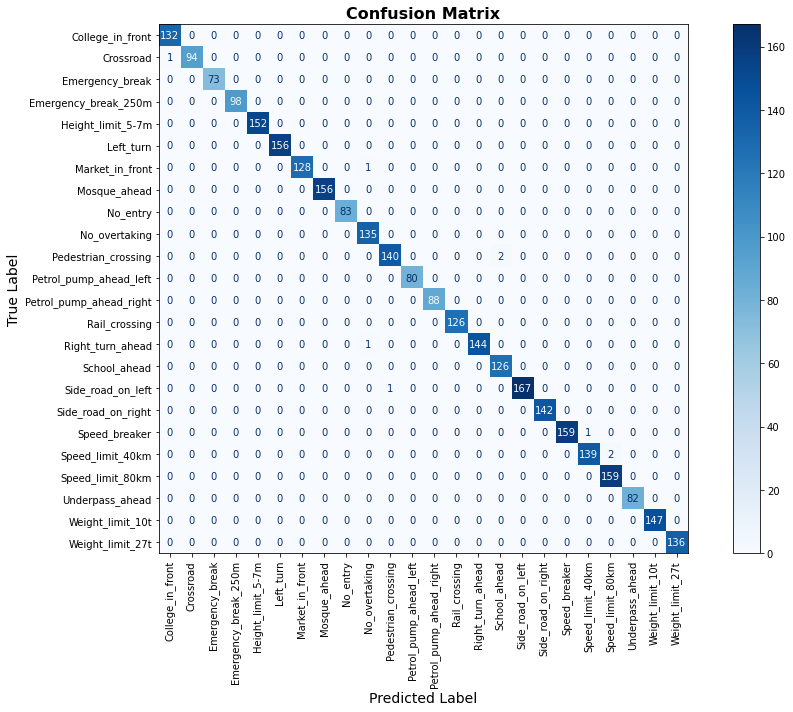

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predicted labels
# Replace these with your actual data
y_true = np.array(y_true_indices)  # Replace with your true labels
y_pred = np.array(y_pred_indices)  # Replace with your predicted labels

# Define the class names based on your provided labels
class_names = [
    "College_in_front",
    "Crossroad",
    "Emergency_break",
    "Emergency_break_250m",
    "Height_limit_5-7m",
    "Left_turn",
    "Market_in_front",
    "Mosque_ahead",
    "No_entry",
    "No_overtaking",
    "Pedestrian_crossing",
    "Petrol_pump_ahead_left",
    "Petrol_pump_ahead_right",
    "Rail_crossing",
    "Right_turn_ahead",
    "School_ahead",
    "Side_road_on_left",
    "Side_road_on_right",
    "Speed_breaker",
    "Speed_limit_40km",
    "Speed_limit_80km",
    "Underpass_ahead",
    "Weight_limit_10t",
    "Weight_limit_27t"
]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(14, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())

# Customize the plot
plt.title("Confusion Matrix", fontsize=16, fontweight="bold")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=90)  # Rotate x-axis labels vertically
plt.grid(False)  # Disable grid for better visibility
plt.tight_layout()
plt.savefig("confusion_matrix_custom_labels.png")  # Save the plot
plt.show()
